In [ ]:
!pip install -q matplotlib 
!pip install -q seaborn
!pip install -q pandas
!pip install -q numpy

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
import io
import os 
import json

In [ ]:
png_dir = "graphs"
json_dir = "fio_results"

bs_map = {
    '4K':4096,
    '16K':16384,
    '1M':1048576,
    '2M':2097152,
    '4M':4194304 
}
bs_order = [
    '4K',
    '16K',
    '1M',
    '2M',
    '4M' 
]

rw_map = {
    'read-':'Sequential Read-only',
    'rw-80':'Sequential Read-heavy 4:1',
    'rw-':'Sequential Balanced 1:1',
    'rw-20':'Sequential Write-heavy 1:4',
    'write-':'Sequential Write-only',
    'randread-':'Random Read-only',
    'randrw-80':'Random Read-heavy 4:1',
    'randrw-':'Random Balanced 1:1',
    'randrw-20':'Random Write-heavy 1:4',
    'randwrite-':'Random Write-only'
}
# wanted to use this dict to label lines.. 
marker_dict = {
    'Sequential Read-only':'SR',
    'Sequential Read-heavy 4:1':'SRH',
    'Sequential Balanced 1:1':'SB',
    'Sequential Write-heavy 1:4':'SWH',
    'Sequential Write-only':'SW',
    'Random Read-only':'RR',
    'Random Read-heavy 4:1':'RRH',
    'Random Balanced 1:1':'RB',
    'Random Write-heavy 1:4':'RWH',
    'Random Write-only':'RW'
}
hue_order = ['Sequential Read-only','Sequential Read-heavy 4:1','Sequential Balanced 1:1','Sequential Write-heavy 1:4','Sequential Write-only','Random Read-only','Random Read-heavy 4:1','Random Balanced 1:1','Random Write-heavy 1:4','Random Write-only']
sequential_full = ['Sequential Read-only','Sequential Read-heavy 4:1','Sequential Balanced 1:1','Sequential Write-heavy 1:4','Sequential Write-only']
random_full = ['Random Read-only','Random Read-heavy 4:1','Random Balanced 1:1','Random Write-heavy 1:4','Random Write-only']

sns.set_style("whitegrid")
# palette = sns.color_palette("magma", 10) 
palette = sns.color_palette("flare", 5) + sns.color_palette("crest", 5)

In [ ]:
# Assemble columns names
rwfile = 'fio_rw_json_example.json'
mixfile = 'fio_mix_json_example.json'
cols = pd.json_normalize(pd.read_json(rwfile)['jobs']).columns.tolist() + pd.json_normalize(pd.read_json(mixfile)['jobs']).columns.tolist() 
cols = list(set(cols))


# Read in json files
first = True
df = pd.DataFrame()
for file_name in os.listdir(json_dir):
    if file_name.endswith('.json'): 
        file = os.path.join(json_dir, file_name)
        print(file_name)
    
        tmp = pd.json_normalize(pd.read_json(file)['jobs'])
        # tmp = tmp.reindex(columns=cols)
    
        for col in tmp.select_dtypes(include=['int', 'int64', 'int32']).columns:
            tmp[col] = tmp[col].astype(float)
    
        if first:
            df = tmp
            first = False
        else:
            # df = pd.merge(tmp, df, how="outer", on=cols)
            df = pd.concat([tmp, df])
df = df.copy()


#### COLUMN NAMES ####
#####   Variables:  
# "job options.iodepth" : io depth
# "job options.numjobs" : number of jobs
# "job options.bs" : block size
# "rw_full" : read write type (human readable)
#
#####   Outputs:    
# "bw_mean" : mean bandwidth
# "iops" : iops
# "lat_ns.mean" : mean latency
# "lat_ns.percentile.99.000000" : 99% latency
######################


# with open("df.txt", 'a') as f:
#     f.write(df.to_string())
df.to_csv("fio_results.csv")


In [ ]:
# Read-Write
df['rw_code'] = df['job options.rw'].str.cat(df['job options.rwmixread'], sep='-', na_rep='')
df["rw_full"] = df["rw_code"].map(rw_map)

# Block Size 
df['bs_num'] = df['job options.bs'].map(bs_map)
df['bs_num'] = df['bs_num'].astype(int)

# Number of Jobs
df["job options.numjobs"] = df["job options.numjobs"].astype(int)

# IO Depth
df["job options.iodepth"] = df["job options.iodepth"].astype(int)

def rand_or_seq(rw_full):
    if rw_full in random_full:
        return 'random'
    elif rw_full in sequential_full:
        return 'sequential'
    else:
        return -1
df['rand_seq_type'] = df['rw_full'].apply(rand_or_seq)

# Helper function to combine mixes/read/write outputs into one column for plotting
def get_var(row, colname):
    var_cols = ['mixed.'+colname, 'read.'+colname, 'write.'+colname]
    for col in var_cols:
        if col in row.index:
            var = row[col]
            if pd.notna(var) and var != 0:
                return var, col
    return np.nan, None

# Bandwidth
df['bw_mean']  = df.apply(lambda row: get_var(row, 'bw_mean')[0], axis=1)
df['bw_mean'] = df['bw_mean']/(1024*1024)

# Iops
df['iops'] = df.apply(lambda row: get_var(row, 'iops')[0], axis=1)
df['iops'] = df['iops'].astype(int)

# Latency
df['lat_ns.mean'] = df.apply(lambda row: get_var(row, 'lat_ns.mean')[0], axis=1)
df['lat_ns.percentile.99.000000'] = df.apply(lambda row: get_var(row, 'lat_ns.percentile.99.000000')[0], axis=1)

subsets = []
for numjobs in df["job options.numjobs"].unique():
    for iodepth in df["job options.iodepth"].unique():
        subdf = df[ (df["job options.numjobs"] == numjobs) & (df["job options.iodepth"] == iodepth) ]
        rows, cols = subdf.shape
        if rows > 0:
            subsets.append(subdf)

In [ ]:
################### BANDWIDTH PLOTS ###################

# BANDWIDTH vs NUMJOBS
for subdf in subsets:
    ax = sns.lineplot(
        data=df,
        x="job options.numjobs",
        y="bw_mean",
        hue="rw_full", 
        style="rw_full",
        # marker=False,
        hue_order=hue_order,
        palette=palette
    )
    # ax.set_aspect('equal')
    ax.set_xticks(df["job options.numjobs"].unique())
    ax.set_xticklabels(df['job options.numjobs'].unique())
    # ax.set_yticks(df['read_bw_mean_gb'])
    # ax.set_yticklabels(df['read_bw_mean_gb'])
    ax.set_xlabel("Number of Jobs")
    ax.set_ylabel("Mean Bandwidth (GiB/s)")
    ax.set_title("Mean Bandwidth vs Number of Jobs ")
    ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type')

    plt.show()
    plt.savefig((png_dir + "/bw_mean_gb-nj.svg"), bbox_inches="tight")
    plt.clf()

In [ ]:
# BANDWIDTH vs BLOCK SIZE
ax = sns.lineplot(
    data=df,
    x="bs_num",
    y="bw_mean",
    hue="rw_full", 
    style="rw_full",
    # marker=False,
    hue_order=hue_order,
    # order=bs_order,
    palette=palette
)
# ax.set_aspect('equal')
ax.set_xticks(df["bs_num"].unique())
ax.set_xticklabels(["4k", "16k", "1M", "2M", "4M"])
# ax.set_yticks(df['read_bw_mean_gb'])
# ax.set_yticklabels(df['read_bw_mean_gb'])
ax.set_xlabel("Block Size")
ax.set_ylabel("Mean Bandwidth (GiB/s)")
ax.set_title("Mean Bandwidth vs Block Size")
ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type')

plt.show()
plt.savefig((png_dir + "/bw_mean_gb-bs.svg"), bbox_inches="tight")
plt.clf()

In [ ]:
for subdf in subsets:
    rows, columns = subdf.shape
    print(rows)

In [ ]:
g = sns.catplot(data=df,
                kind="bar",
                x="job options.bs",
                hue="rw_full", 
                y="bw_mean",
                row="job options.numjobs",
                col="job options.iodepth",
                # palette=palette,
                # width=5,
                hue_order=hue_order,
                order=bs_order,
                errorbar=None,
                height=5, aspect=1.5,
                sharex=True, sharey=True
                )
# g.set_xticklabels(["4k", "16k", "1M", "2M", "4M"]) 
g.set_ylabels("Bandwidth (GiB/s)")
g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(g.axes.flat):
    ax.tick_params(
        labelbottom=True,  # show x labels
        labelleft=True     # show y labels
    )

plt.show()
plt.savefig((png_dir + "/fio_bw_vs_bs_allD.svg"), bbox_inches="tight")
plt.clf()


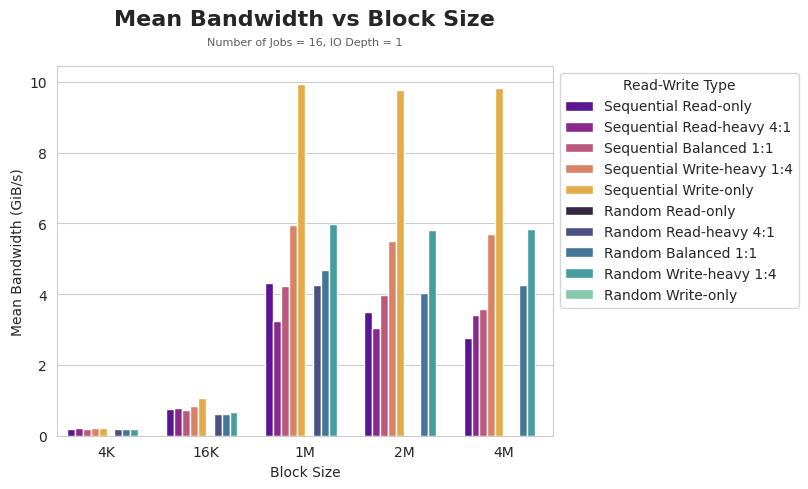

<Figure size 640x480 with 0 Axes>

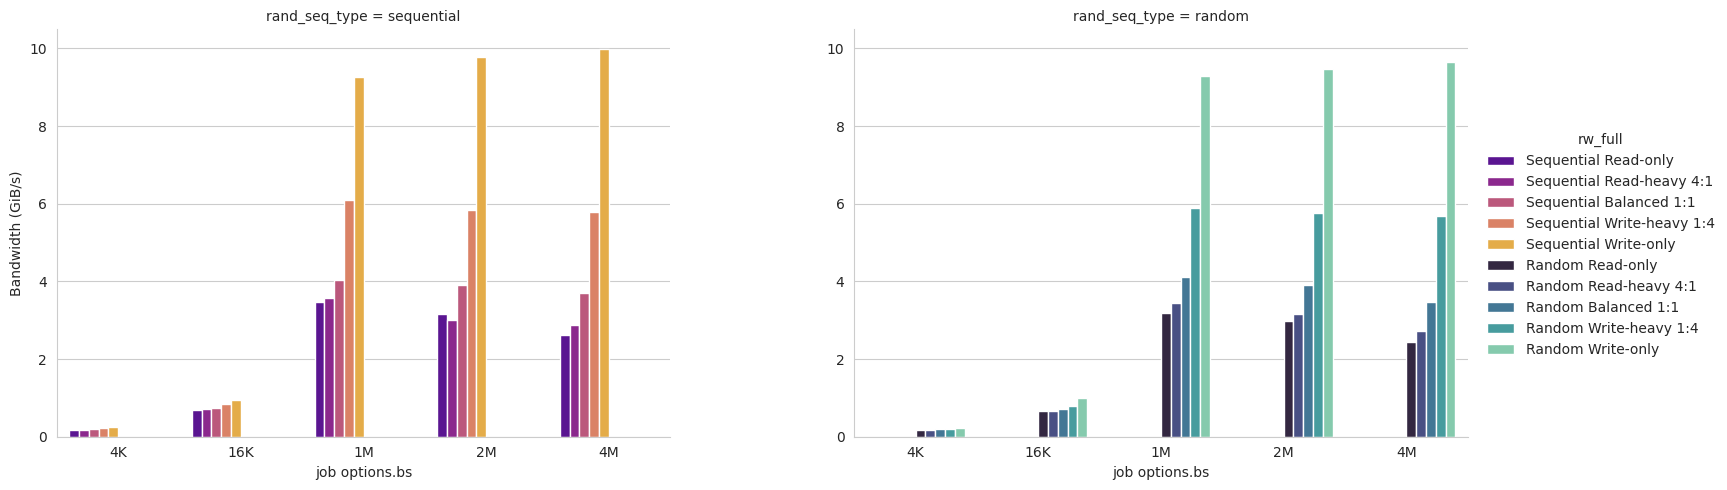

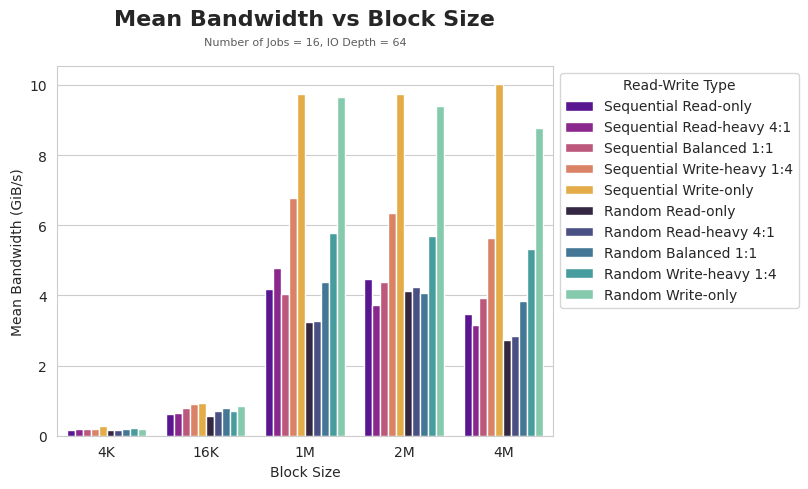

<Figure size 640x480 with 0 Axes>

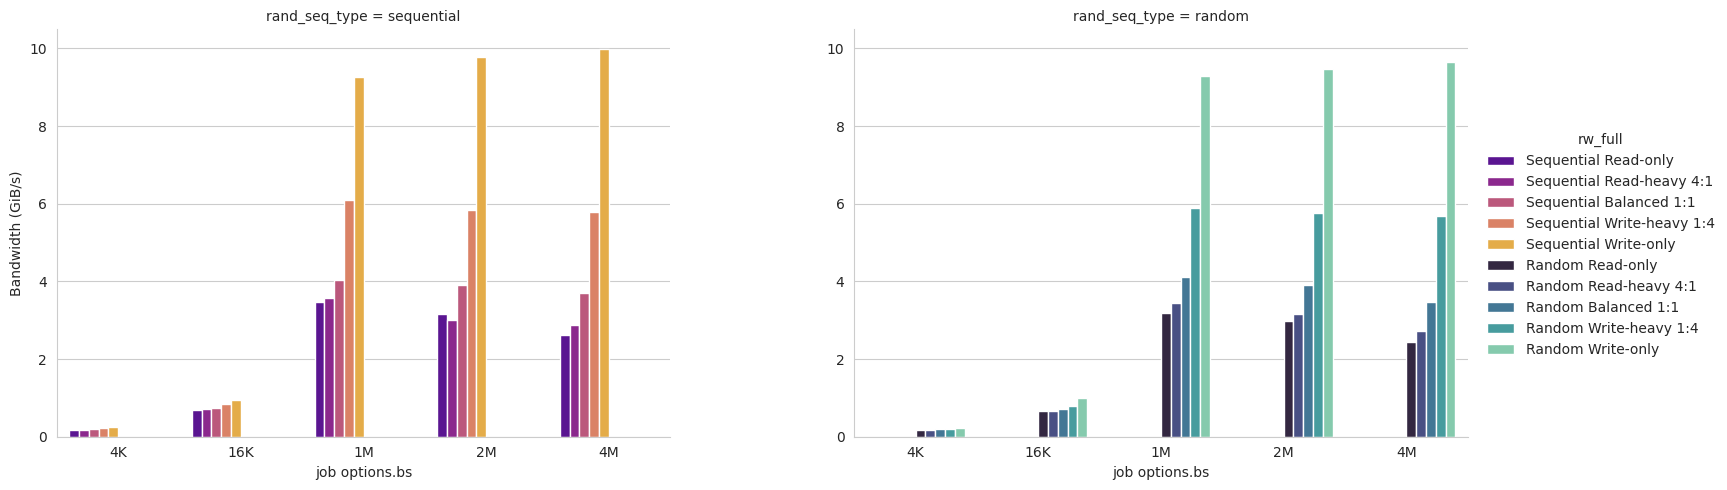

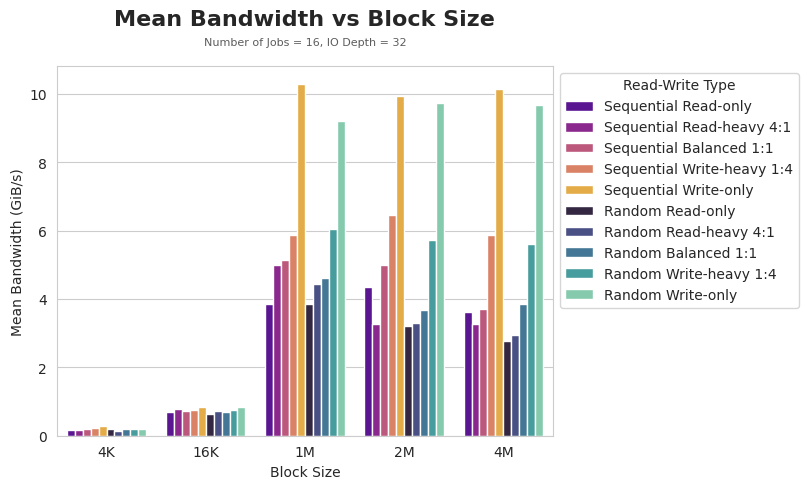

<Figure size 640x480 with 0 Axes>

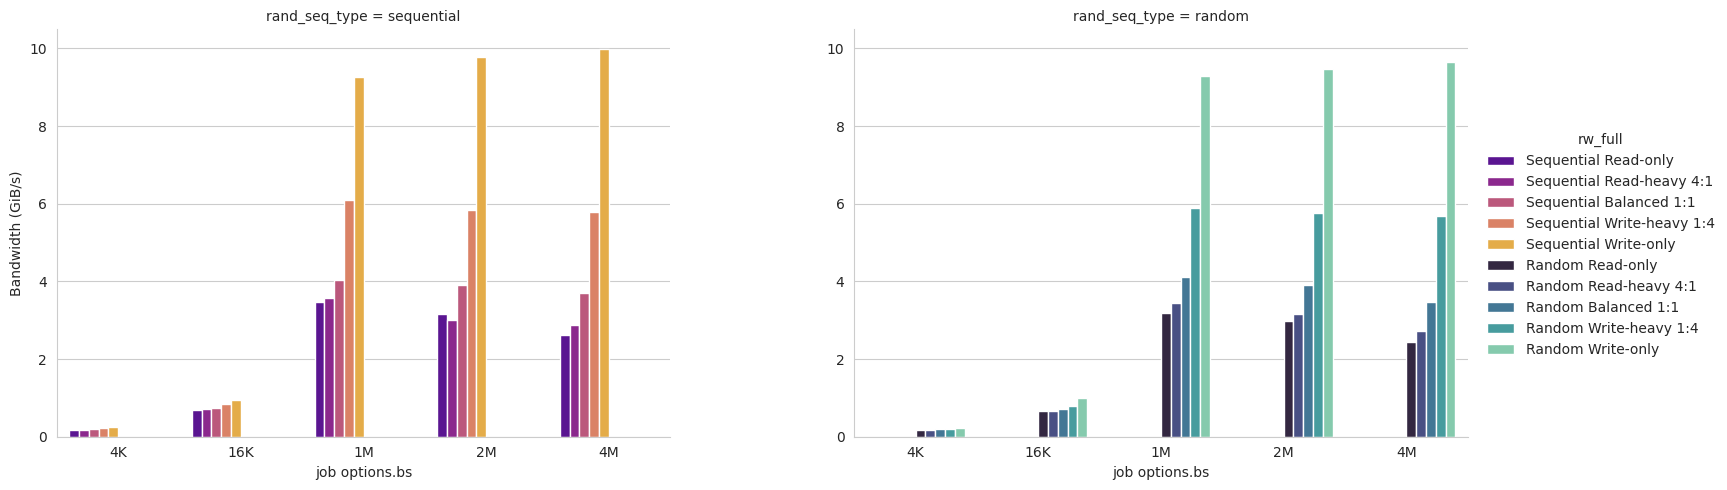

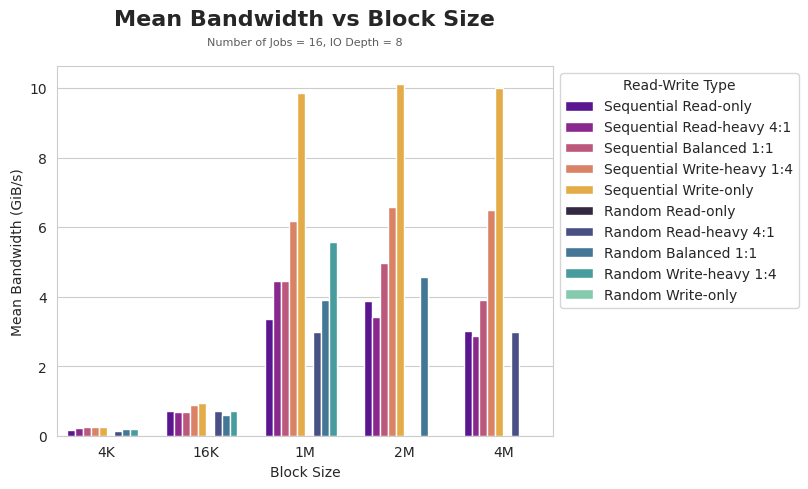

<Figure size 640x480 with 0 Axes>

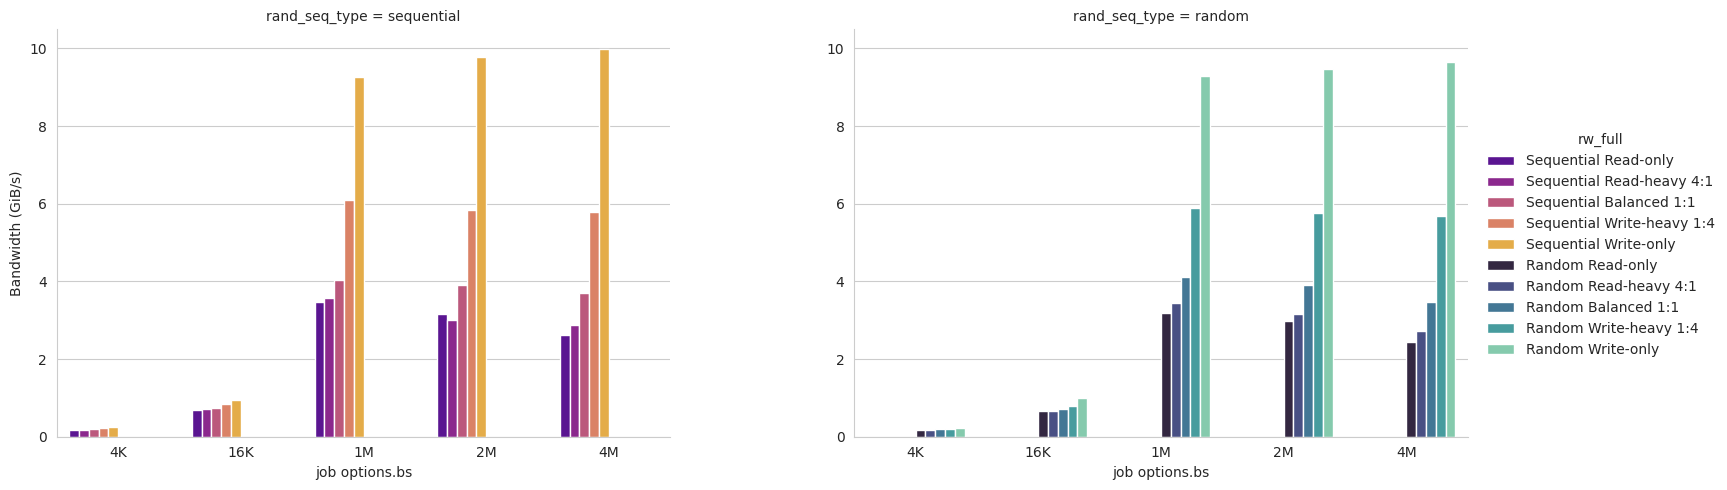

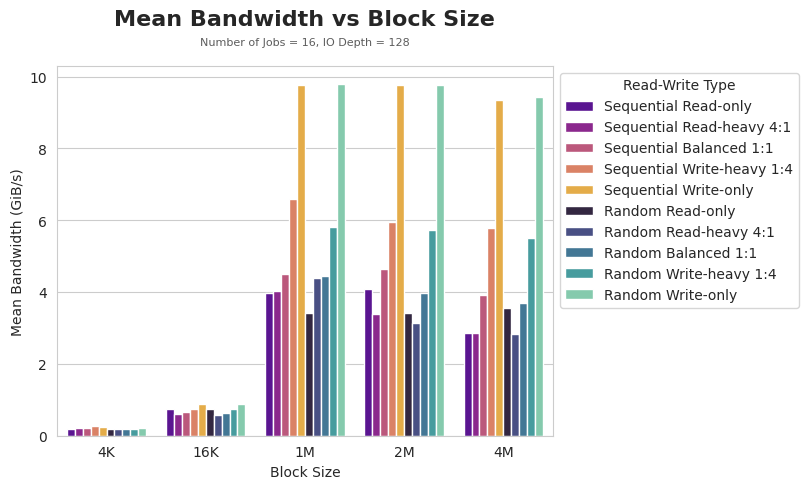

<Figure size 640x480 with 0 Axes>

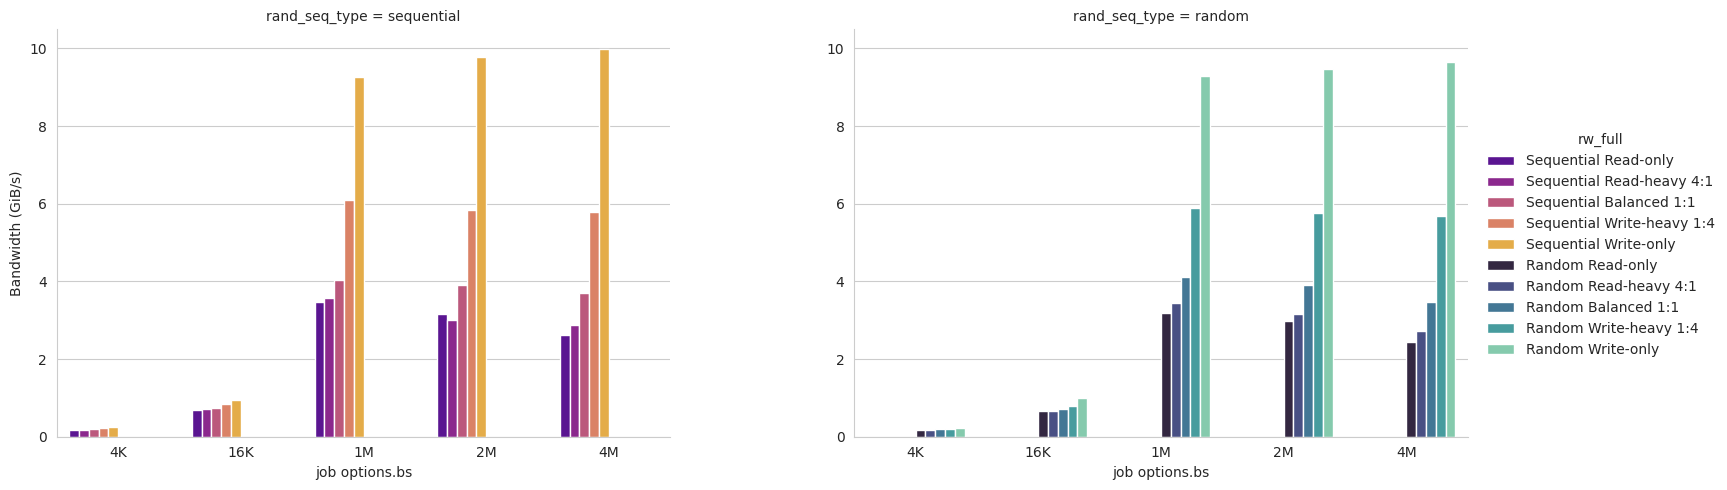

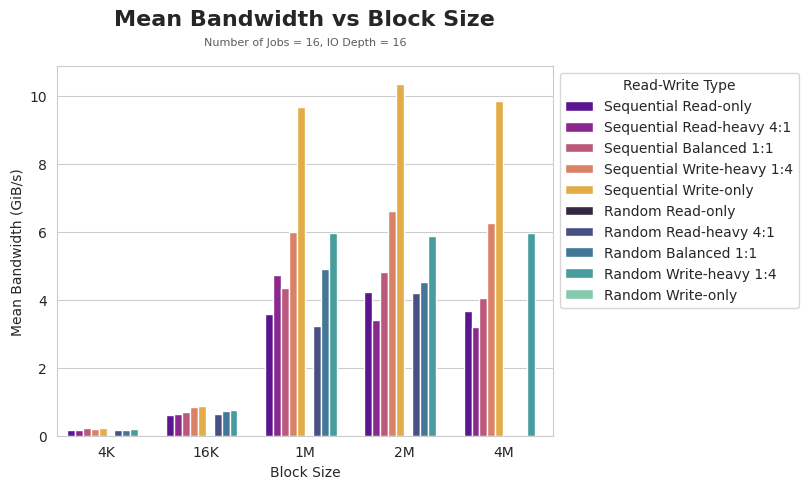

<Figure size 640x480 with 0 Axes>

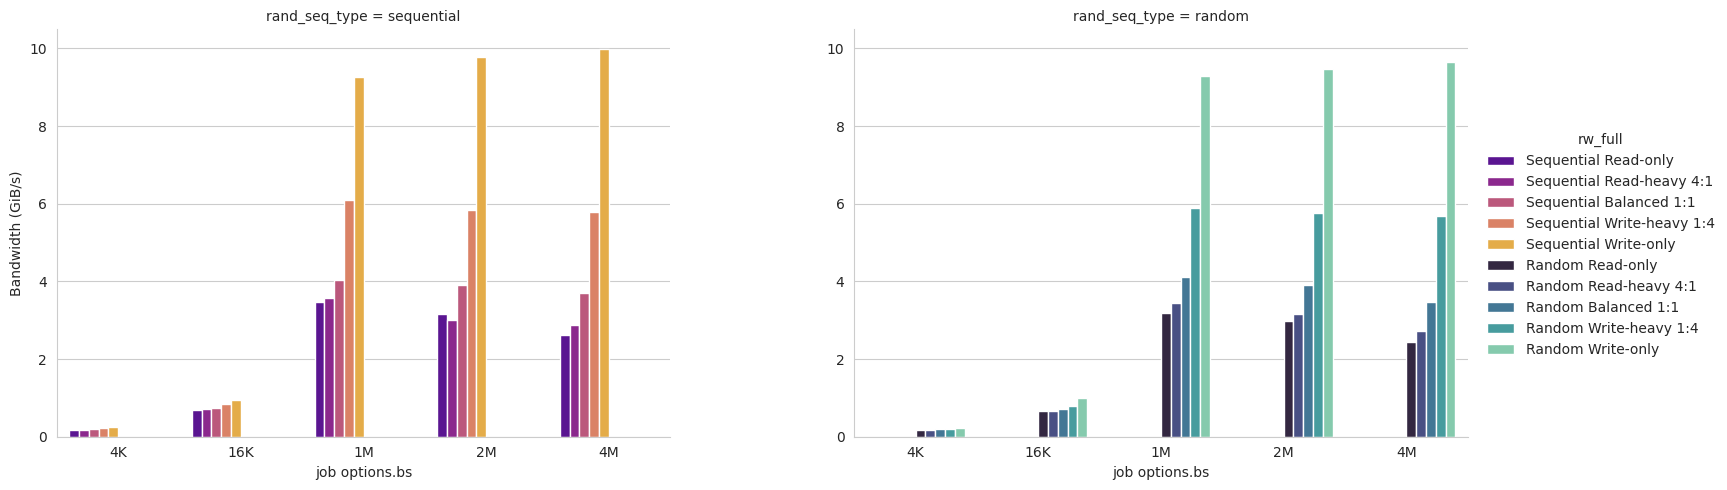

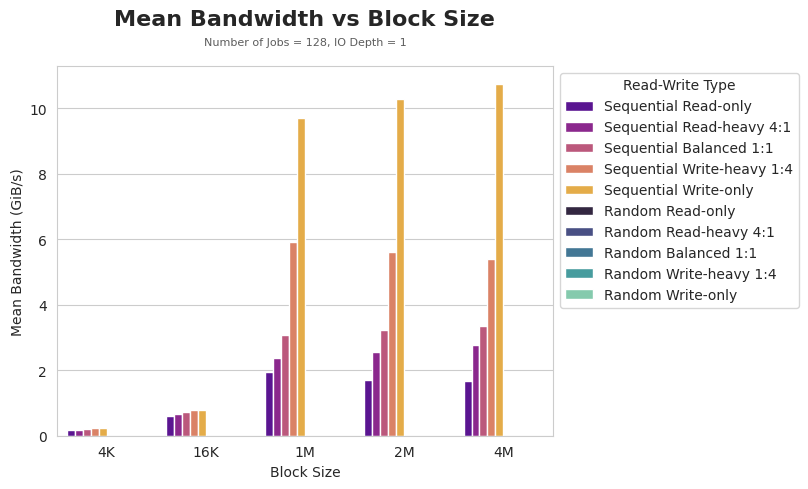

<Figure size 640x480 with 0 Axes>

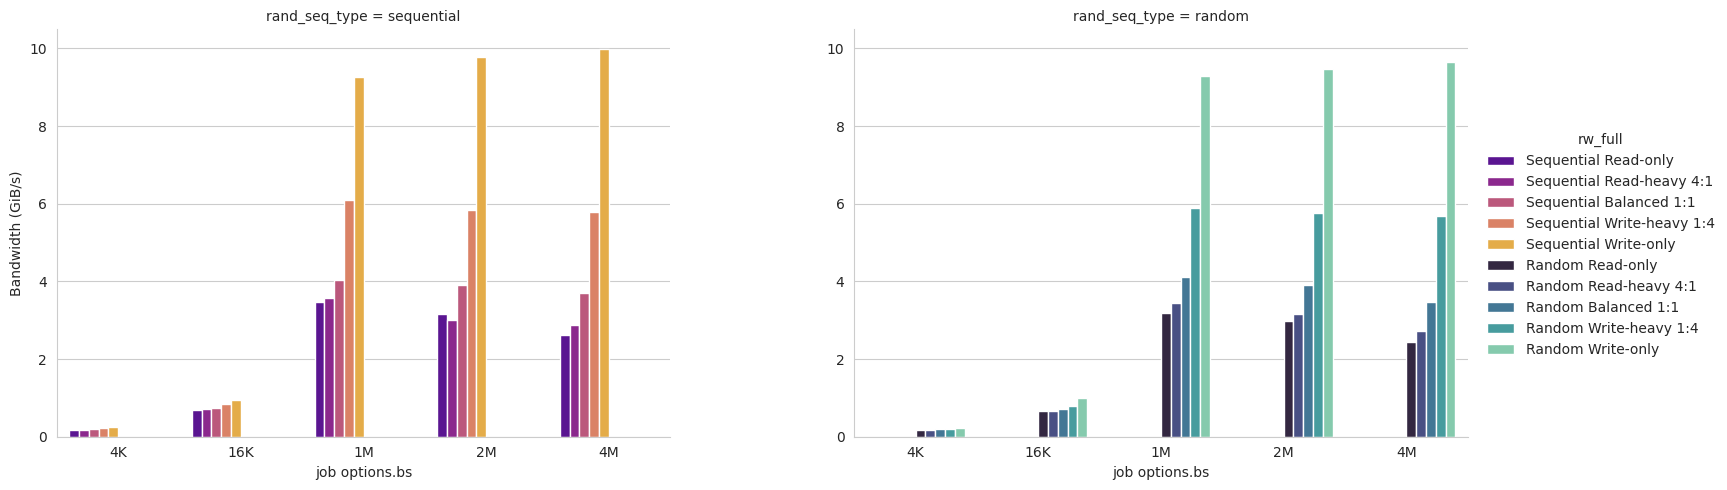

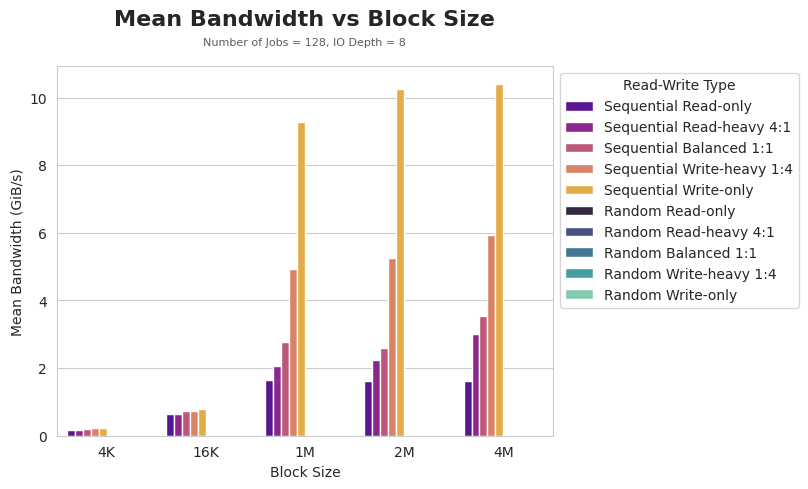

<Figure size 640x480 with 0 Axes>

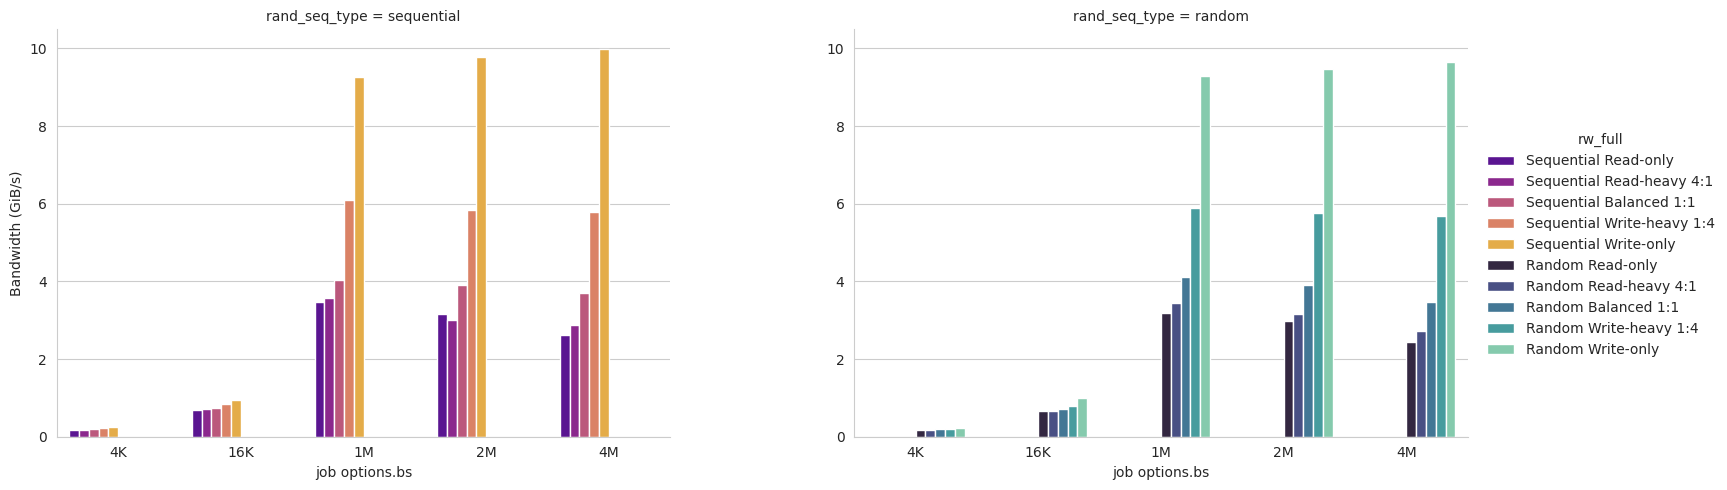

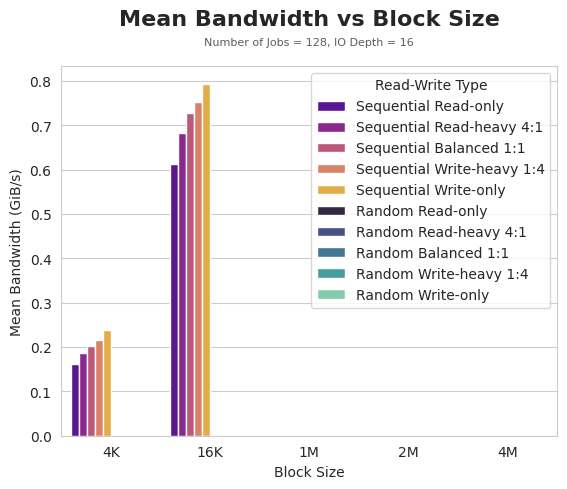

<Figure size 640x480 with 0 Axes>

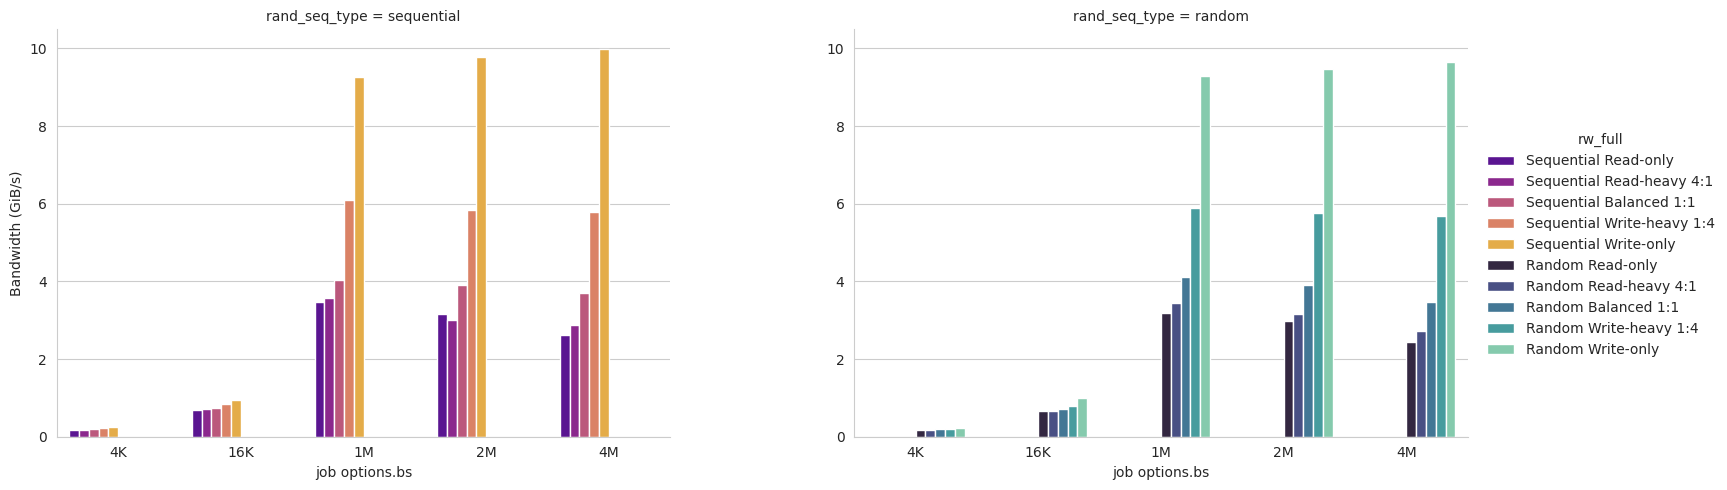

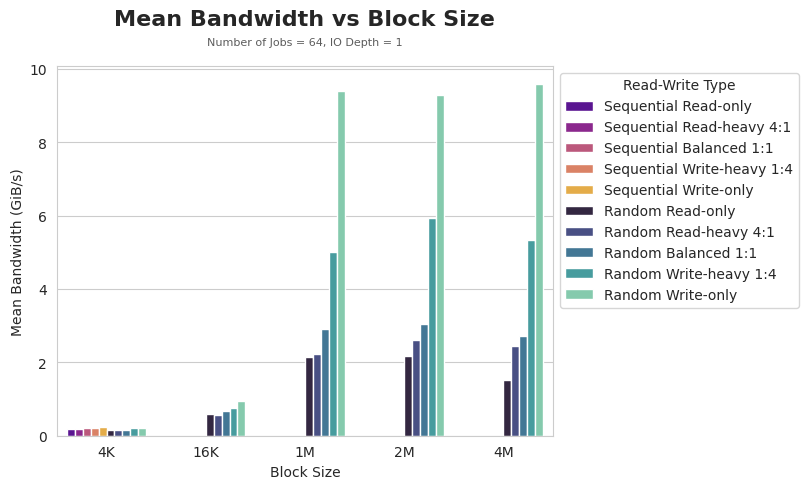

<Figure size 640x480 with 0 Axes>

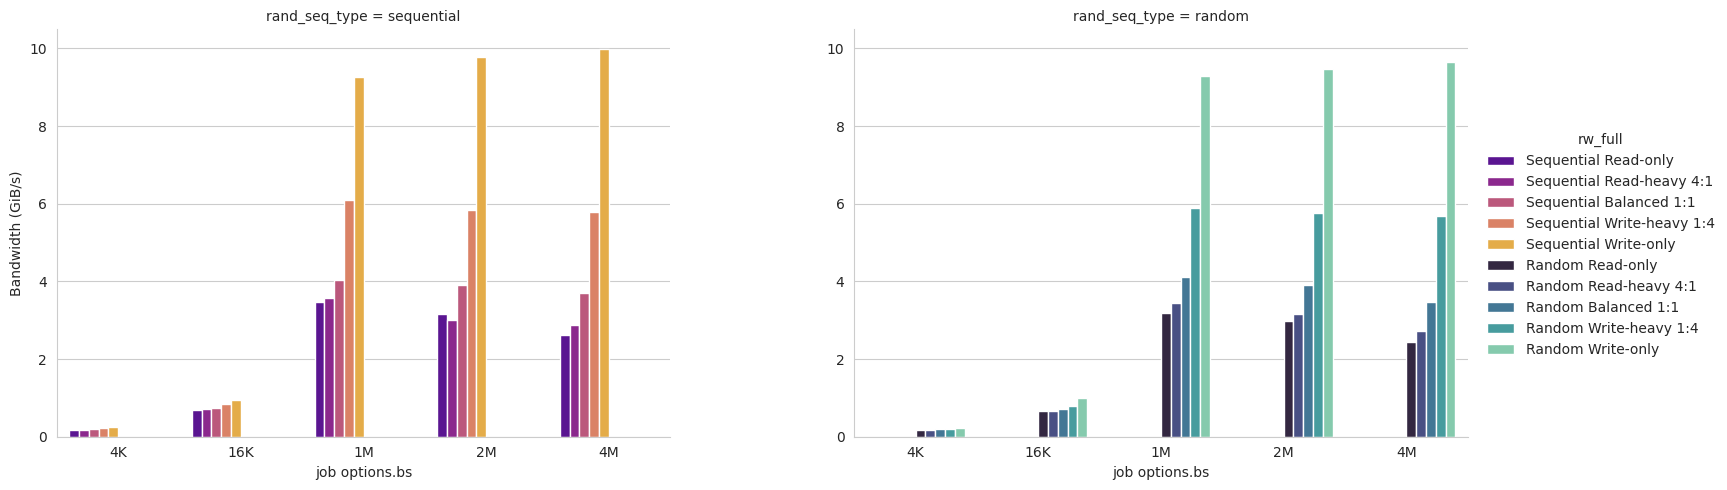

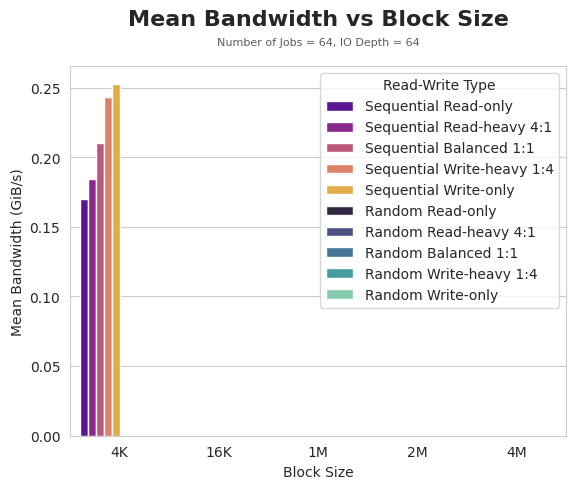

<Figure size 640x480 with 0 Axes>

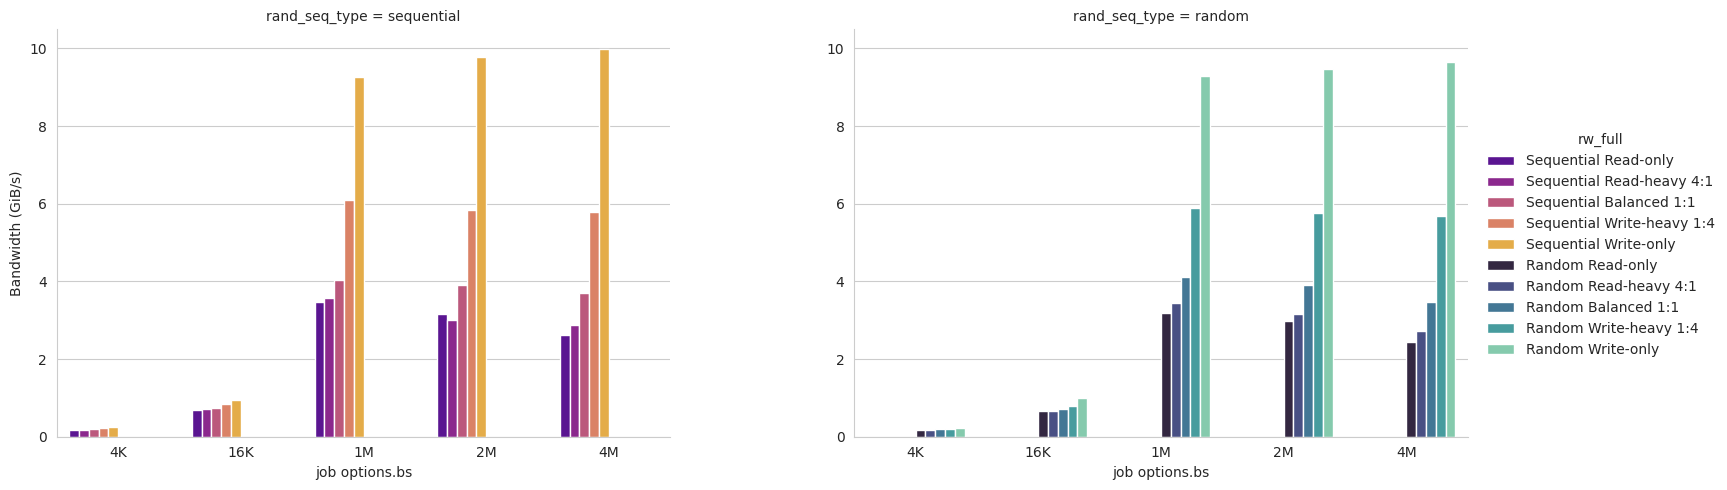

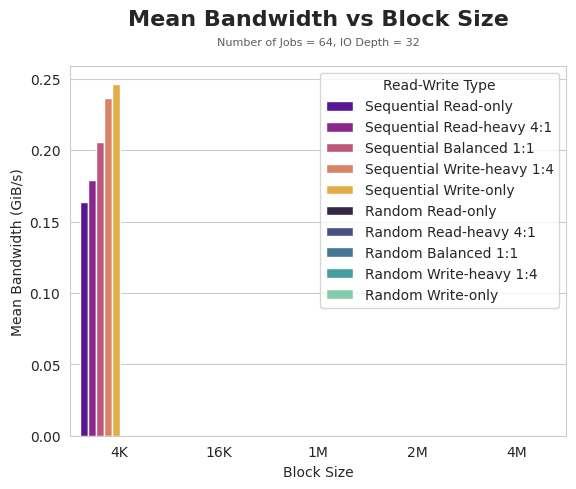

<Figure size 640x480 with 0 Axes>

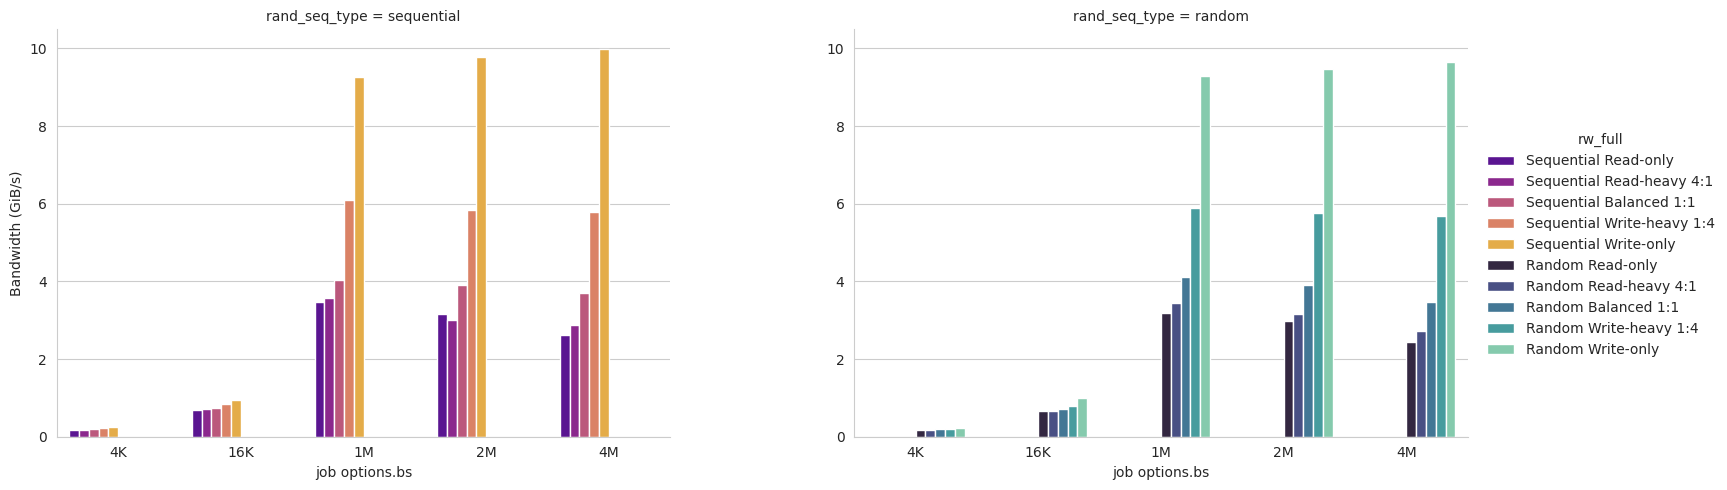

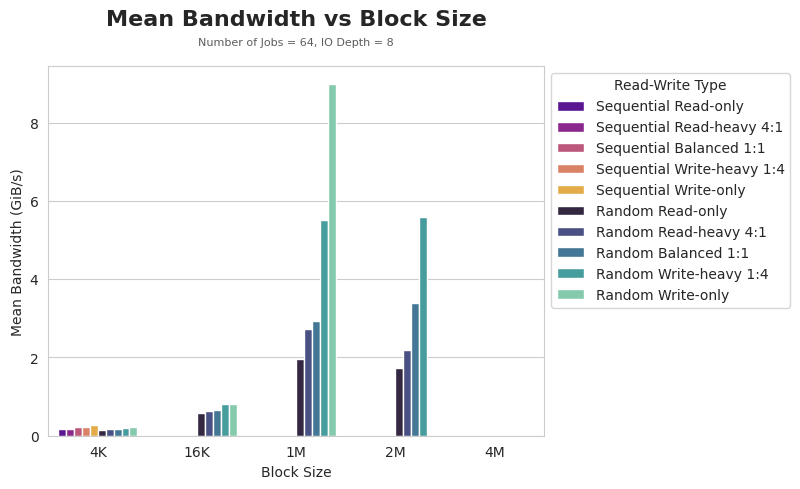

<Figure size 640x480 with 0 Axes>

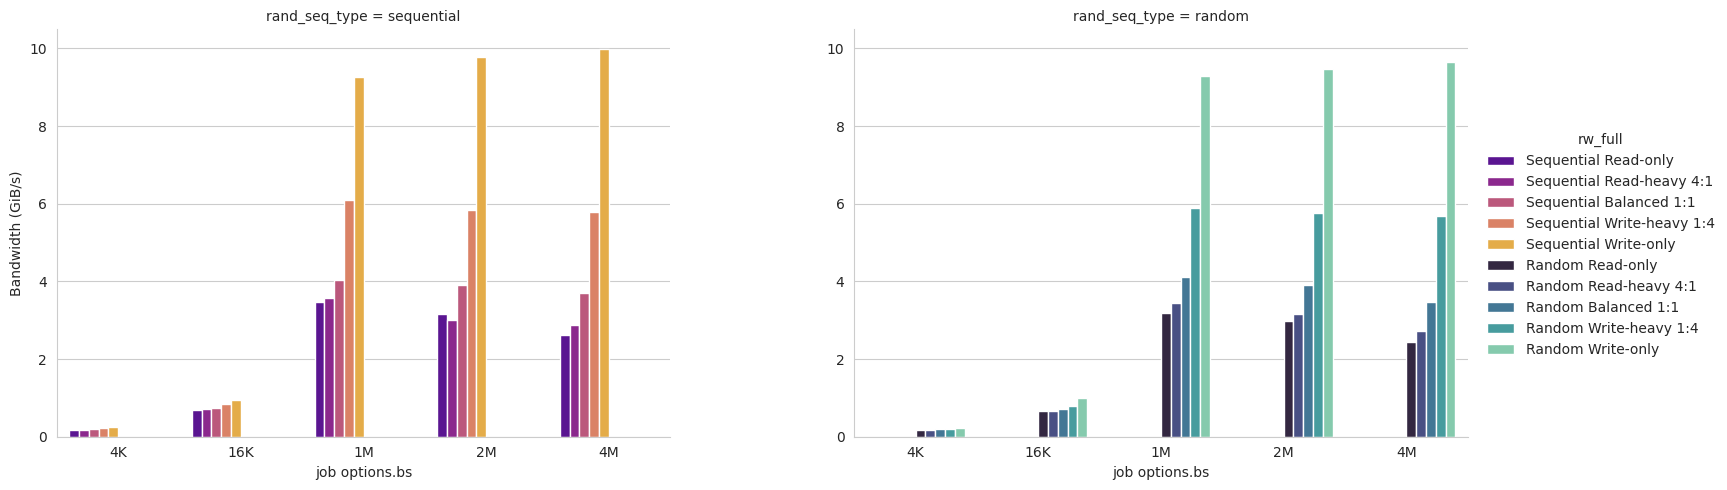

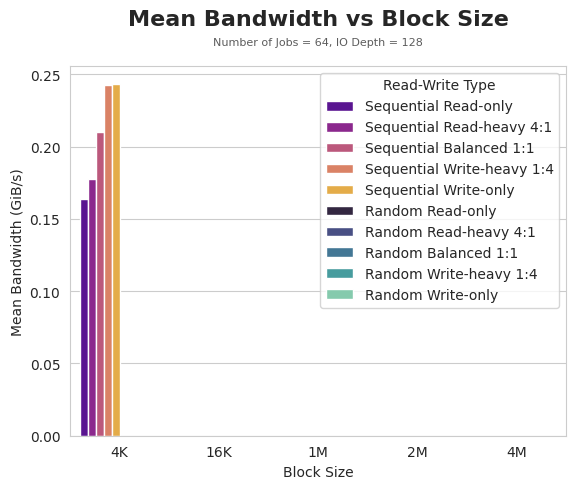

<Figure size 640x480 with 0 Axes>

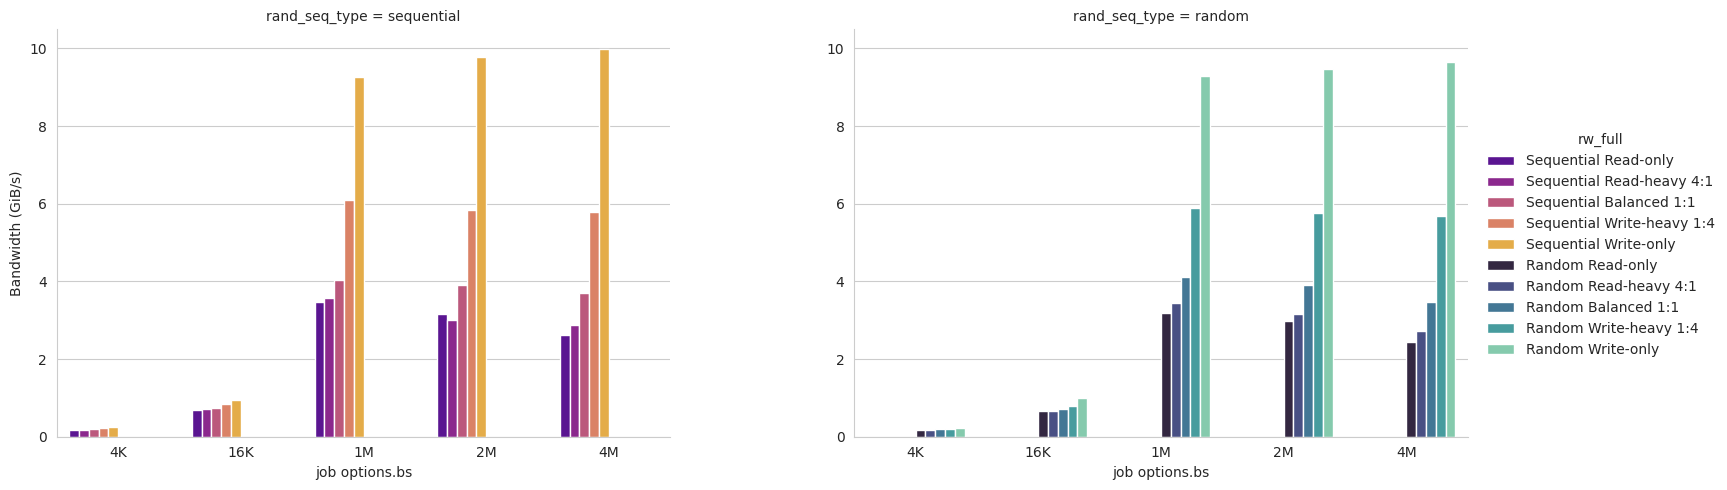

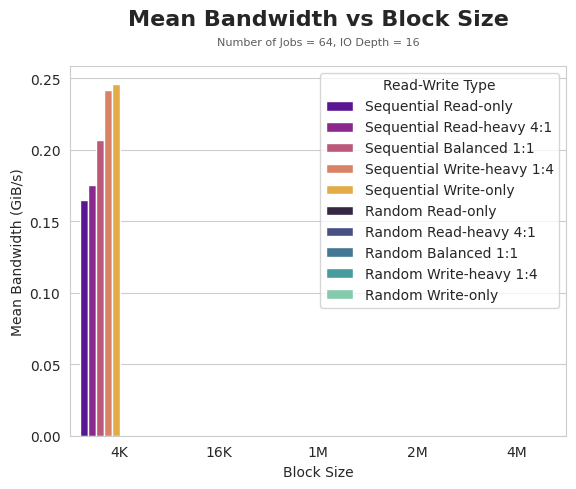

<Figure size 640x480 with 0 Axes>

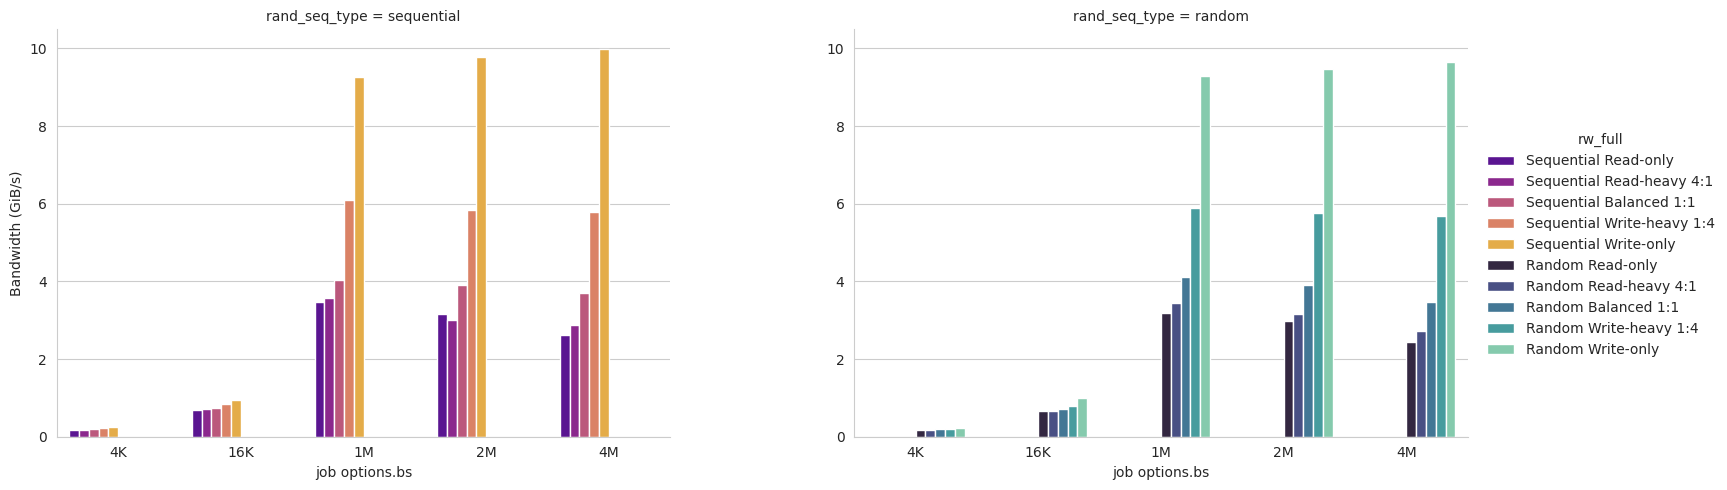

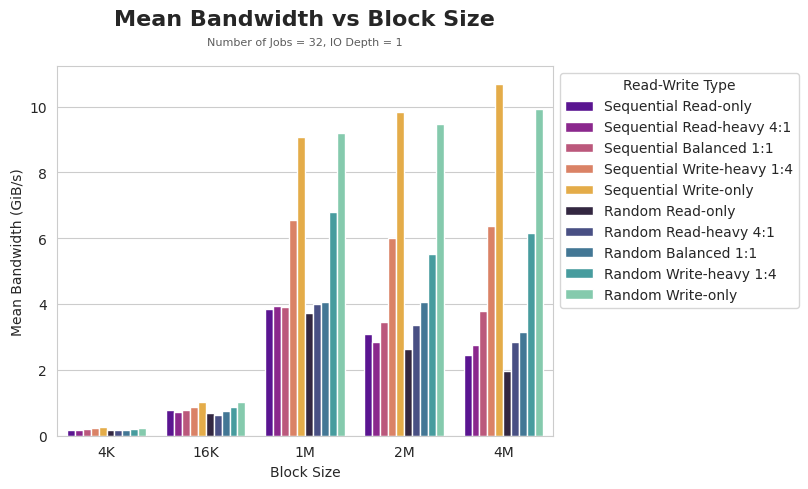

<Figure size 640x480 with 0 Axes>

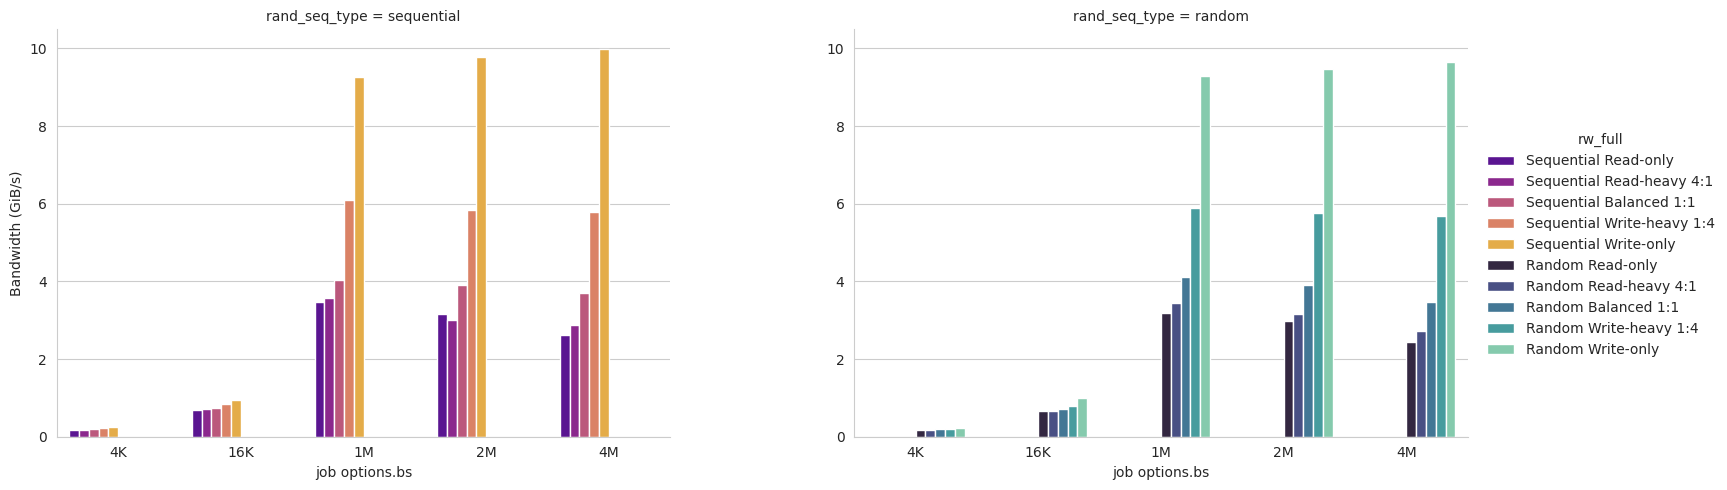

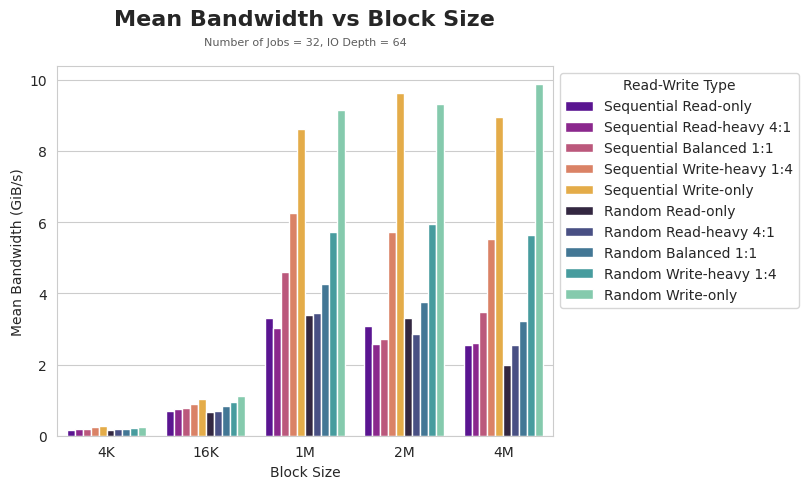

<Figure size 640x480 with 0 Axes>

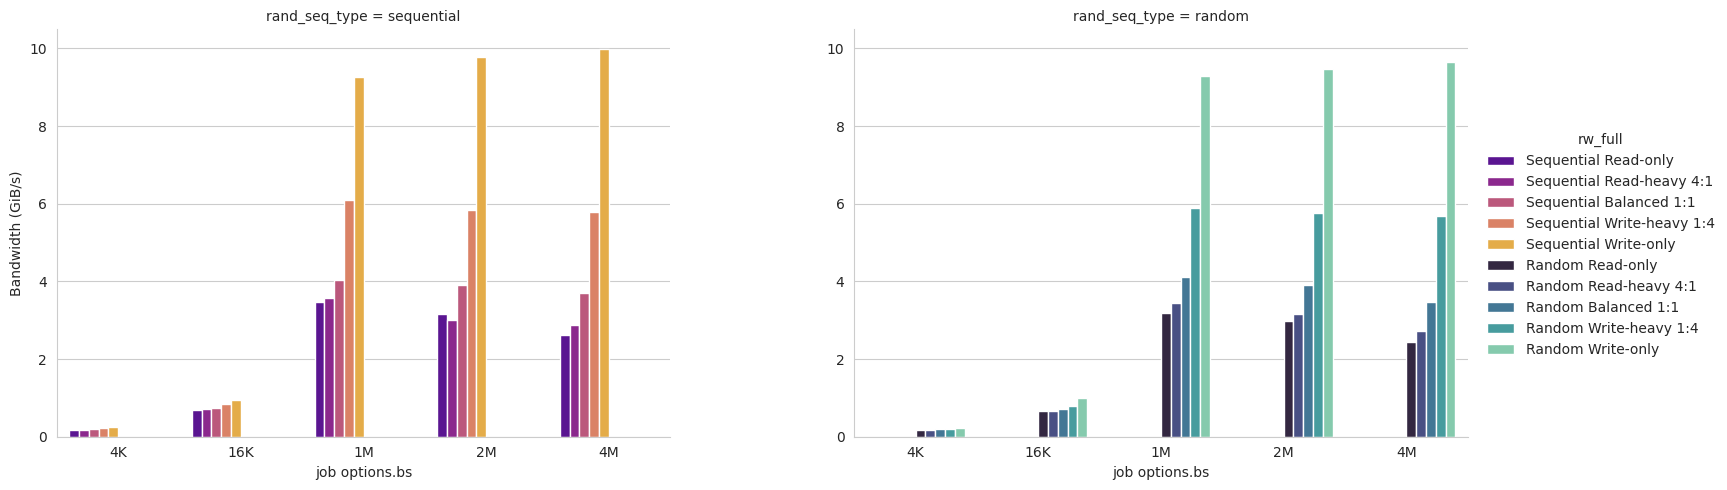

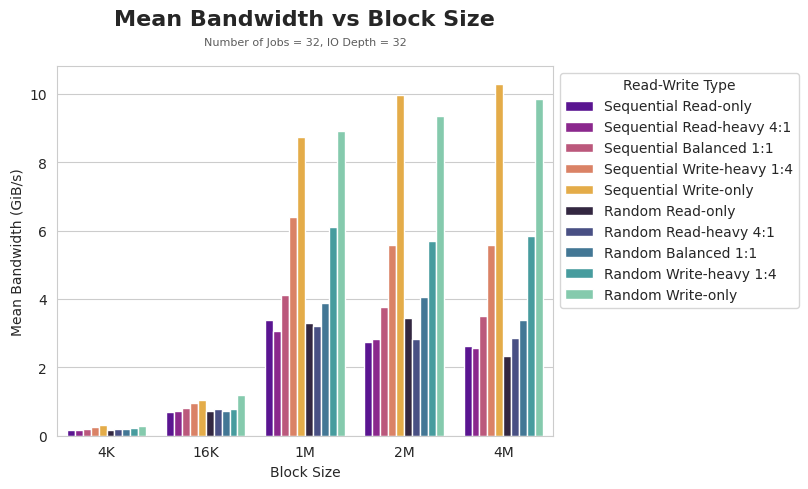

<Figure size 640x480 with 0 Axes>

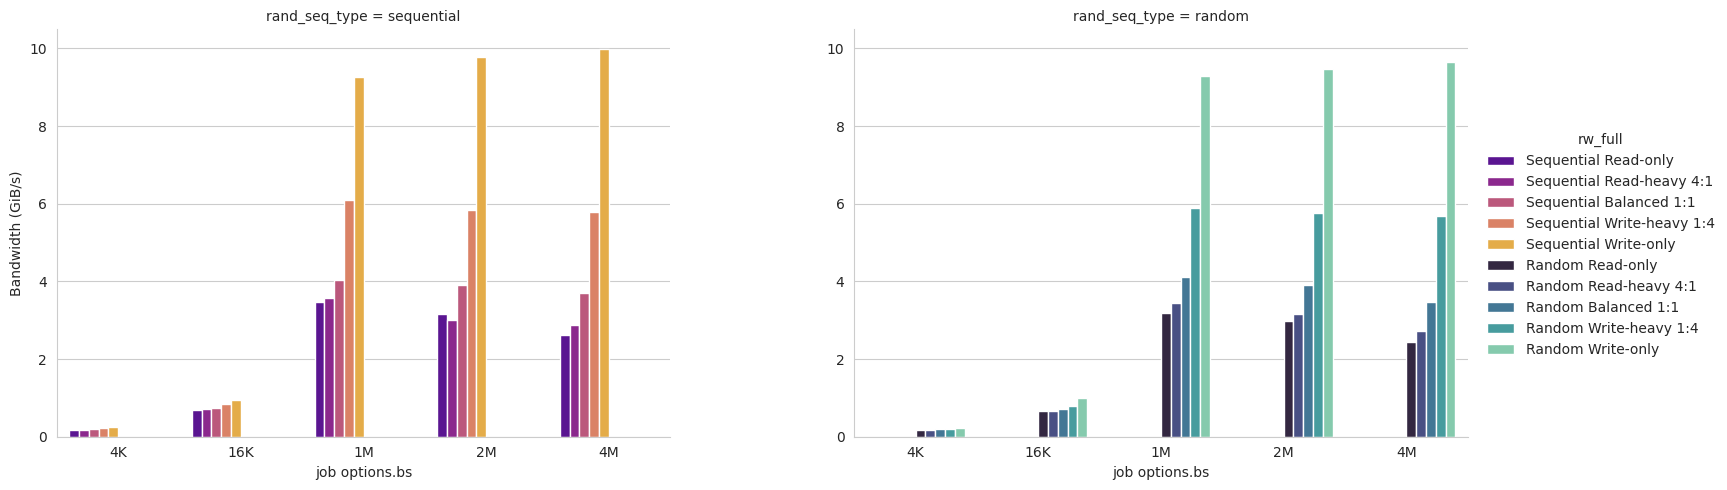

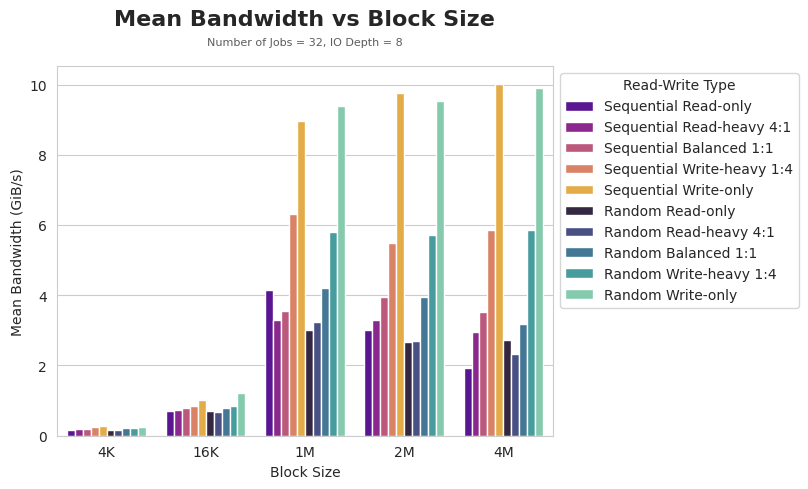

<Figure size 640x480 with 0 Axes>

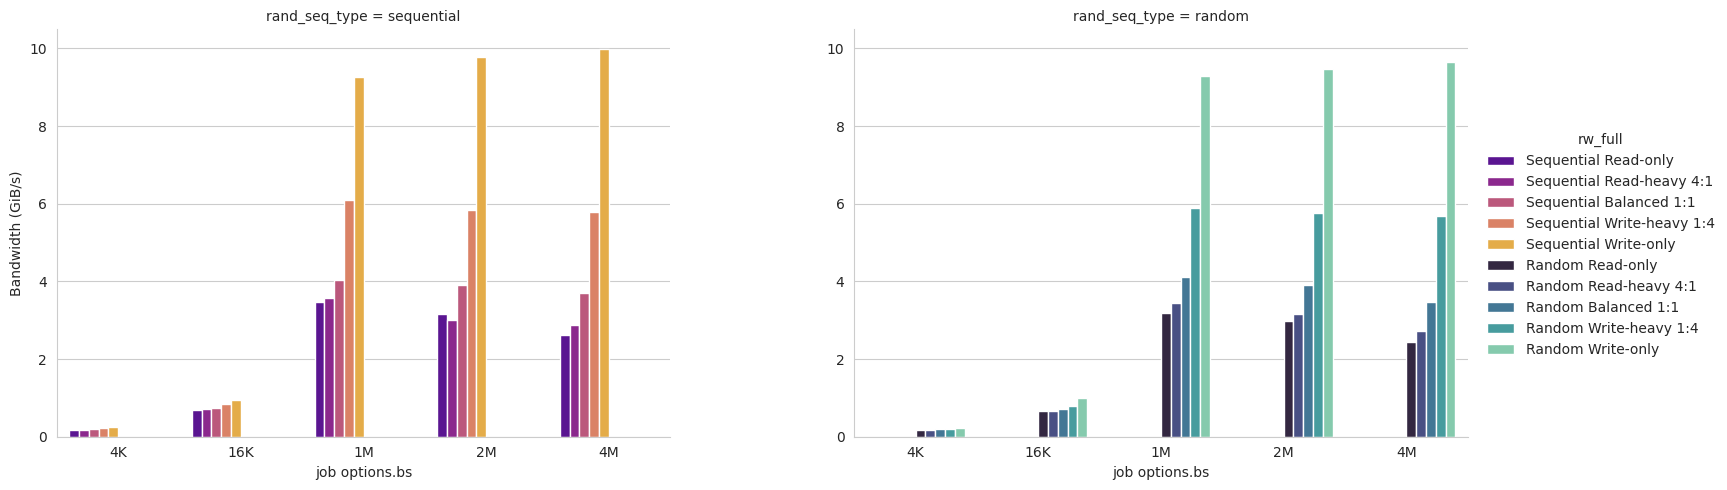

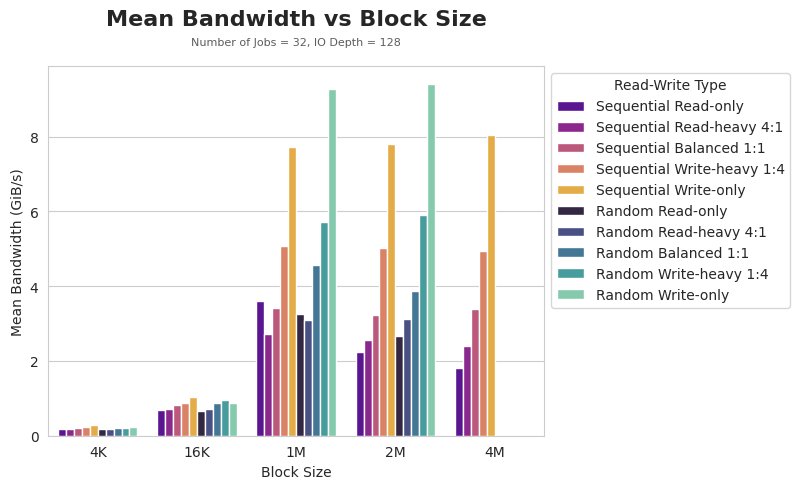

<Figure size 640x480 with 0 Axes>

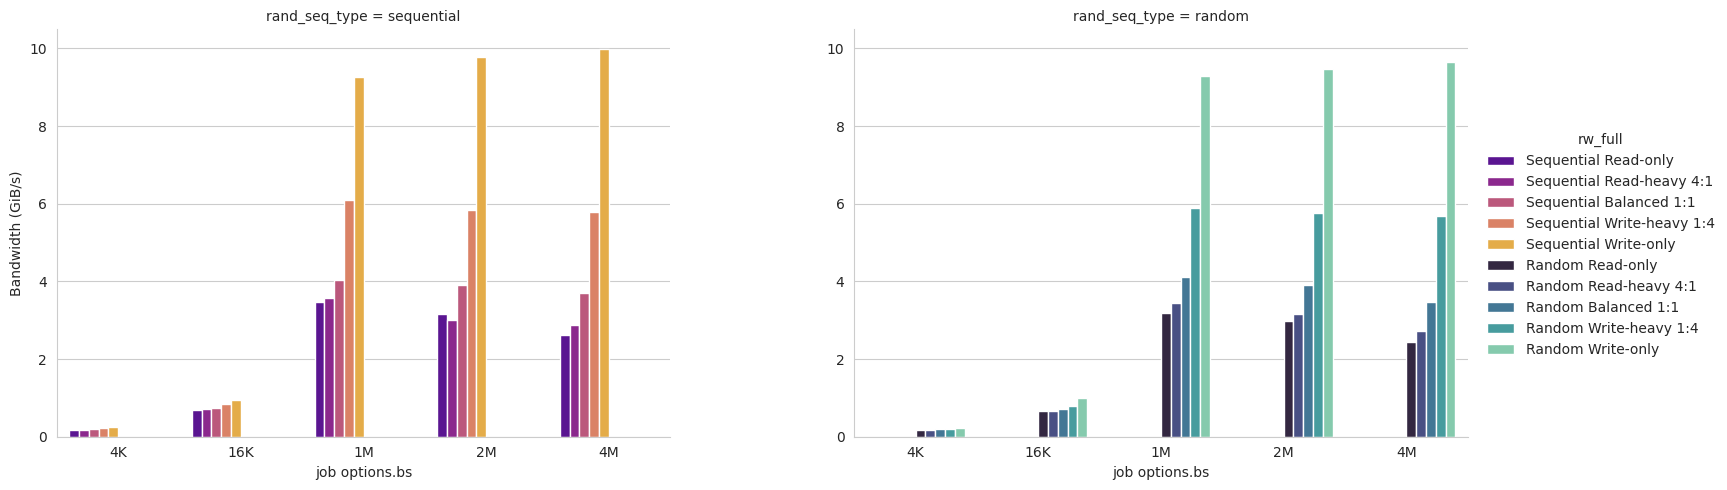

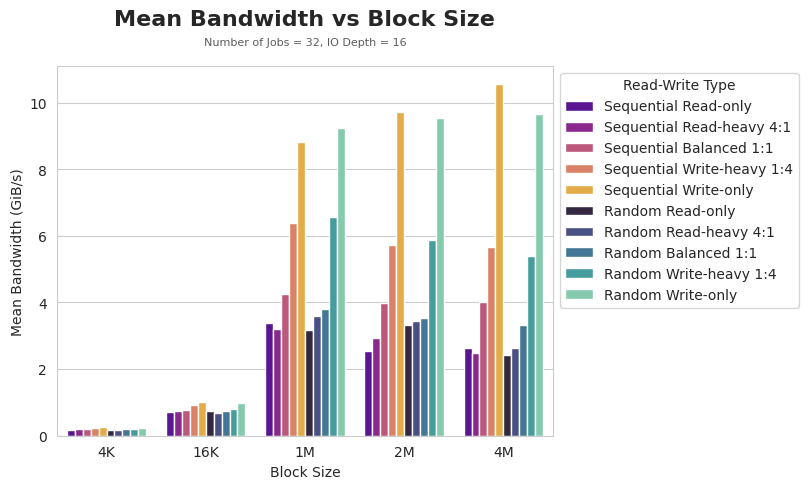

<Figure size 640x480 with 0 Axes>

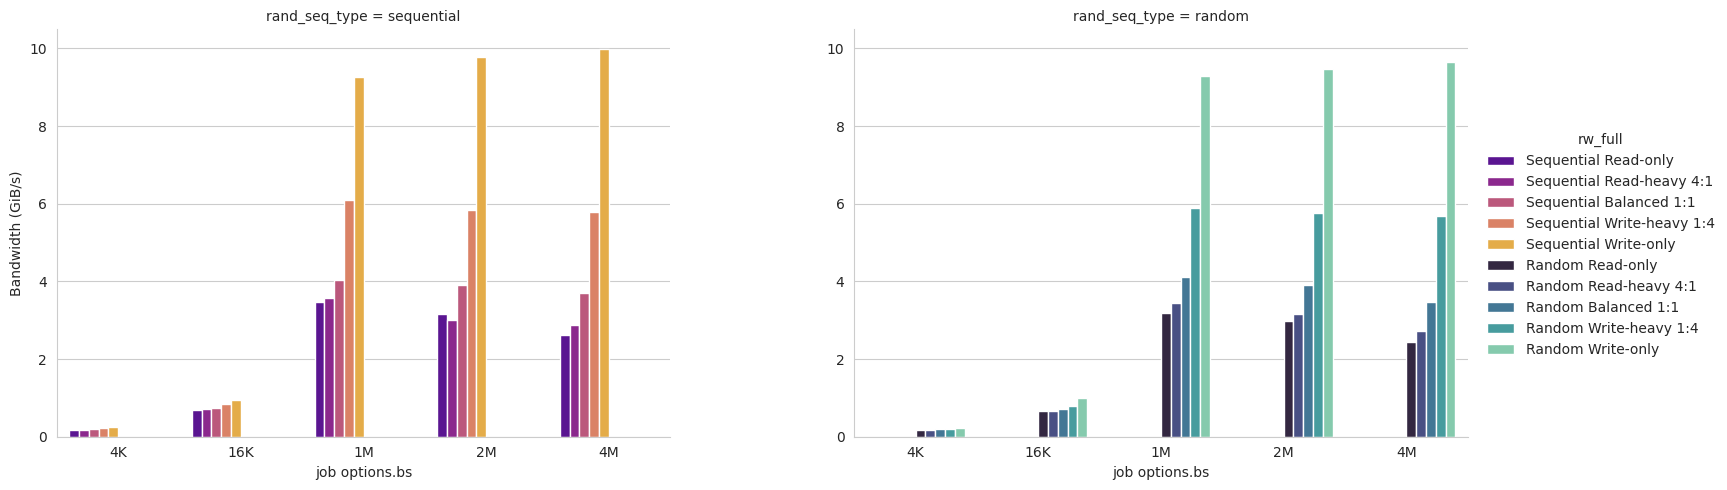

<Figure size 640x480 with 0 Axes>

In [65]:
palette = sns.color_palette("plasma", 5) + sns.color_palette("mako", 5)

for subdf in subsets:
    nj = subdf['job options.numjobs'].iloc[0]
    iod = subdf['job options.iodepth'].iloc[0]

    # FULL
    ax = sns.barplot(
        data=subdf,
        x="job options.bs",
        y="bw_mean",
        hue="rw_full", 
        hue_order=hue_order,
        order=bs_order,
        palette=palette,
        errorbar=None
    )
    ax.set_xlabel("Block Size")
    ax.set_ylabel("Mean Bandwidth (GiB/s)")
    ax.text(x=0.5, y=1.1, s="Mean Bandwidth vs Block Size", fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    ax.text(x=0.5, y=1.05, s=f"Number of Jobs = {nj}, IO Depth = {iod}", fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
    ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type')

    plt.show()
    plt.savefig((png_dir + "/fio_bw_vs_bs_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
    plt.clf()

    # SEQUENTIAL/RANDOM SIDE BY SIDE
    g = sns.catplot(data=df,
                kind="bar",
                x="job options.bs",
                y="bw_mean",
                hue="rw_full",
                col="rand_seq_type", 
                order=bs_order,
                hue_order=hue_order,
                palette=palette,
                errorbar=None,
                height=5, aspect=1.5,
                sharex=True, sharey=True
                )
    # g.set_xticklabels(["4k", "16k", "1M", "2M", "4M"]) 
    g.set_ylabels("Bandwidth (GiB/s)")
    g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(g.axes.flat):
        ax.tick_params(
            labelbottom=True,  # show x labels
            labelleft=True     # show y labels
        )

    plt.show()
    plt.savefig((png_dir + f"/fio_bw_vs_bs_SR_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
    plt.clf()

    # # SEQUENTIAL
    # subdf_s = subdf[subdf['rw_full'].isin(sequential_full)]
    # ax = sns.barplot(
    #     data=subdf_s,
    #     x="job options.bs",
    #     y="bw_mean",
    #     hue="rw_full", 
    #     hue_order=hue_order,
    #     order=bs_order,
    #     errorbar=None
    # )
    # ax.set_xlabel("Block Size")
    # ax.set_ylabel("Mean Bandwidth (GiB/s)")
    # ax.text(x=0.5, y=1.1, s="Mean Bandwidth vs Block Size", fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    # ax.text(x=0.5, y=1.05, s=f"Number of Jobs = {nj}, IO Depth = {iod}", fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
    # ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type')

    # plt.show()
    # plt.savefig((png_dir + f"/fio_bw_vs_bs_S_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
    # plt.clf()

    # # RANDOM
    # subdf_r = subdf[subdf['rw_full'].isin(random_full)]
    # ax = sns.barplot(
    #     data=subdf_r,
    #     x="job options.bs",
    #     y="bw_mean",
    #     hue="rw_full", 
    #     hue_order=hue_order,
    #     order=bs_order,
    #     errorbar=None
    # )
    # ax.set_xlabel("Block Size")
    # ax.set_ylabel("Mean Bandwidth (GiB/s)")
    # ax.text(x=0.5, y=1.1, s="Mean Bandwidth vs Block Size", fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    # ax.text(x=0.5, y=1.05, s=f"Number of Jobs = {nj}, IO Depth = {iod}", fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
    # ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type')

    # plt.show()
    # plt.savefig((png_dir + f"/fio_bw_vs_bs_R_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
    # plt.clf()



In [ ]:
g = sns.catplot(data=df,
                kind="bar",
                x="job options.bs",
                hue="rw_full", 
                y="bw_mean",
                row="job options.numjobs",
                col="job options.iodepth",
                # palette=palette,
                # width=5,
                hue_order=hue_order,
                order=bs_order,
                errorbar=None,
                height=5, aspect=1.5,
                sharex=True, sharey=True
                )
# g.set_xticklabels(["4k", "16k", "1M", "2M", "4M"]) 
g.set_ylabels("Bandwidth (GiB/s)")
g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(g.axes.flat):
    ax.tick_params(
        labelbottom=True,  # show x labels
        labelleft=True     # show y labels
    )

plt.show()
plt.savefig((png_dir + "/fio_bw_vs_bs_allD.svg"), bbox_inches="tight")
plt.clf()

for subdf in subsets:
    print(subdf['job options.numjobs'].iloc[0])
    nj = subdf['job options.numjobs'].iloc[0]
    print(subdf['job options.iodepth'].iloc[0])
    iod = subdf['job options.iodepth'].iloc[0]
    ax = sns.barplot(
        data=df,
        x="job options.bs",
        y="bw_mean",
        hue="rw_full", 
        hue_order=hue_order,
        order=bs_order,
        errorbar=None
    )
    ax.set_xlabel("Block Size")
    ax.set_ylabel("Mean Bandwidth (GiB/s)")
    ax.set_title("Mean Bandwidth vs Block Size", fontsize=16)
    ax.text(f"Number of Jobs = {nj}, IO Depth = {iod}", loc='center', y=0.9, fontsize=12)
    ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type')

    plt.show(bbox_inches="tight")
    plt.savefig((png_dir + "/fio_bw_vs_bs_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
    plt.clf()

In [ ]:
# print(df['job options.numjobs'].unique())
# # print(df['job options.numjobs'])
# print(df['job options.numjobs'].isna().sum())
# for subdf in subsets:

# print(f'nj: {subsets[0]['job options.numjobs'].iloc[0]}')
    # nj = subdf['job options.numjobs'][0]
    # print(subdf['job options.iodepth'][0])
    # iod = subdf['job options.iodepth'][0]

In [ ]:

################### IOPS PLOTS ###################

# IOPS vs NUMJOBS
ax = sns.lineplot(
    data=df,
    x="job options.numjobs",
    y="iops",
    hue="rw_full", 
    style="rw_full",
    # marker=False,
    # hue_order=hue_order,
    palette=palette
)
# ax.set_aspect('equal')
ax.set_xticks(df["job options.numjobs"].unique())
ax.set_xticklabels(df['job options.numjobs'].unique())
# ax.set_yticks(df['read_bw_mean_gb'])
# ax.set_yticklabels(df['read_bw_mean_gb'])
ax.set_xlabel("Number of Jobs")
ax.set_ylabel("IOPS")
ax.set_title("IOPS vs Number of Jobs ")
# ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type')
plt.savefig((png_dir + "/iops-nj.svg"), bbox_inches="tight")
plt.clf()


# IOPS vs BLOCK SIZE
ax = sns.lineplot(
    data=df,
    x="bs_num",
    y="iops",
    hue="rw_full", 
    style="rw_full",
    # marker=False,
    # hue_order=hue_order,
    palette=palette
)
# ax.set_aspect('equal')
ax.set_xticks(df["bs_num"].unique())
ax.set_xticklabels(df['bs_num'].unique())
# ax.set_yticks(df['read_bw_mean_gb'])
# ax.set_yticklabels(df['read_bw_mean_gb'])
ax.set_xlabel("Block Size")
ax.set_ylabel("IOPS")
ax.set_title("IOPS vs Block Size")
ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type')
plt.savefig((png_dir + "/iops-bs.svg"), bbox_inches="tight")
plt.clf()

g = sns.catplot(data=df,
                kind="bar",
                x="job options.bs", 
                hue="rw_full", 
                y="iops",
                row="job options.numjobs",
                col="job options.iodepth",
                # palette=palette,
                # width=5,
                hue_order=hue_order,
                order=bs_order,
                height=5, aspect=1.5
                # sharex=False
                )
g.set_ylabels("IOPS") 
g.set_xticklabels(["4k", "16k", "1M", "2M", "4M"])   
for ax in g.axes.flat:
    # ax.set_ylabel("IOPS")
    # ax.tick_params(axis='x', labelbottom=True)  
    # ax.set_xticklabels(["4k", "16k", "1M", "2M", "4M"])   
    ax.margins(x=0.1)
    # for container in ax.containers:
        # ax.bar_label(container)
        # hue_label = container.get_label()  # This gets the hue value
        # for bar in container:
        #     x_pos = bar.get_x() + bar.get_width() / 2
        #     y_pos = ax.get_ylim()[0] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05  # Position below x-axis
        #     ax.text(x_pos, y_pos, hue_label, 
        #            ha='center', va='top', 
        #            fontsize=8, rotation=45)

g.savefig((png_dir + "/iops-bs-bars.svg"), bbox_inches="tight")
plt.clf()

In [ ]:
################## LATENCY PLOTS ###################

# MEAN LATENCY vs NUMJOBS
ax = sns.lineplot(
    data=df,
    x="job options.numjobs",
    y="lat_ns.mean",
    hue="rw_full", 
    style="rw_full",
    # marker=False,
    # hue_order=hue_order,
    palette=palette
)
# ax.set_aspect('equal')
ax.set_xticks(df["job options.numjobs"].unique())
ax.set_xticklabels(df['job options.numjobs'].unique())
# ax.set_yticks(df['read_bw_mean_gb'])
# ax.set_yticklabels(df['read_bw_mean_gb'])
ax.set_xlabel("Number of Jobs")
ax.set_ylabel("Mean Latency (ns)")
ax.set_title("Mean Latency (ns) vs Number of Jobs ")
# ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type')
plt.savefig((png_dir + "/mean-lat-nj.svg"), bbox_inches="tight")
plt.clf()


# MEAN LATENCY vs BLOCK SIZE
ax = sns.lineplot(
    data=df,
    x="bs_num",
    y="lat_ns.mean",
    hue="rw_full", 
    style="rw_full",
    # marker=False,
    # hue_order=hue_order,
    palette=palette
)
# ax.set_aspect('equal')
ax.set_xticks(df["bs_num"].unique())
ax.set_xticklabels(df['bs_num'].unique())
# ax.set_yticks(df['read_bw_mean_gb'])
# ax.set_yticklabels(df['read_bw_mean_gb'])
ax.set_xlabel("Block Size")
ax.set_ylabel("Mean Latency (ns)")
ax.set_title("Mean Latency (ns) vs Block Size")
ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type')
plt.savefig((png_dir + "/mean-lat-bs.svg"), bbox_inches="tight")
plt.clf()

g = sns.catplot(data=df,
                kind="bar",
                x="job options.bs", 
                hue="rw_full", 
                y="lat_ns.mean",
                row="job options.numjobs",
                col="job options.iodepth",
                # palette=palette,
                # width=5,
                hue_order=hue_order,
                order=bs_order,
                height=5, aspect=1.5
                # sharex=False
                )
g.set_ylabels("Mean Latency (ns)")
g.set_xticklabels(["4k", "16k", "1M", "2M", "4M"]) 
for ax in g.axes.flat:
      
    ax.margins(x=0.1)
    # for container in ax.containers:
        # ax.bar_label(container)
        # hue_label = container.get_label()  # This gets the hue value
        # for bar in container:
        #     x_pos = bar.get_x() + bar.get_width() / 2
        #     y_pos = ax.get_ylim()[0] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05  # Position below x-axis
        #     ax.text(x_pos, y_pos, hue_label, 
        #            ha='center', va='top', 
        #            fontsize=8, rotation=45)

g.savefig((png_dir + "/mean-lat-bs-bars.svg"), bbox_inches="tight")
plt.clf()


In [ ]:

# 99 LATENCY vs NUMJOBS
ax = sns.lineplot(
    data=df,
    x="job options.numjobs",
    y="lat_ns.percentile.99.000000",
    hue="rw_full", 
    style="rw_full",
    # marker=False,
    # hue_order=hue_order,
    palette=palette
)
# ax.set_aspect('equal')
ax.set_xticks(df["job options.numjobs"].unique())
ax.set_xticklabels(df['job options.numjobs'].unique())
# ax.set_yticks(df['read_bw_mean_gb'])
# ax.set_yticklabels(df['read_bw_mean_gb'])
ax.set_xlabel("Number of Jobs")
ax.set_ylabel("99th Percentile Latency (ns)")
ax.set_title("99th Percentile Latency (ns) vs Number of Jobs ")
# ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type')
plt.savefig((png_dir + "/mean-lat-nj-99.svg"), bbox_inches="tight")
plt.clf()


# 99 LATENCY vs BLOCK SIZE
ax = sns.lineplot(
    data=df,
    x="bs_num",
    y="lat_ns.percentile.99.000000",
    hue="rw_full", 
    style="rw_full",
    # marker=False,
    # hue_order=hue_order,
    palette=palette
)
# ax.set_aspect('equal')
ax.set_xticks(df["bs_num"].unique())
ax.set_xticklabels(df['bs_num'].unique())
# ax.set_yticks(df['read_bw_mean_gb'])
# ax.set_yticklabels(df['read_bw_mean_gb'])
ax.set_xlabel("Block Size")
ax.set_ylabel("99th Percentile Latency (ns)")
ax.set_title("99th Percentile Latency (ns) vs Block Size")
ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type')
plt.savefig((png_dir + "/mean-lat-bs-99.svg"), bbox_inches="tight")
plt.clf()

In [ ]:

g = sns.catplot(data=df,
                kind="bar",
                x="job options.bs", 
                hue="rw_full", 
                y="lat_ns.percentile.99.000000",
                row="job options.numjobs",
                col="job options.iodepth",
                # palette=palette,
                # width=5,
                hue_order=hue_order,
                order=bs_order,
                height=5, aspect=1.5
                # sharex=False
                )
g.set_ylabels("99th Percentile Latency (ns)")
g.set_xticklabels(["4k", "16k", "1M", "2M", "4M"])  
for ax in g.axes.flat:
    # ax.set_ylabel("99th Percentile Latency (ns)")
    # ax.tick_params(axis='x', labelbottom=True)  
    # ax.set_xticklabels(["4k", "16k", "1M", "2M", "4M"])   
    ax.margins(x=0.1)
    # for container in ax.containers:
        # ax.bar_label(container)
        # hue_label = container.get_label()  # This gets the hue value
        # for bar in container:
        #     x_pos = bar.get_x() + bar.get_width() / 2
        #     y_pos = ax.get_ylim()[0] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05  # Position below x-axis
        #     ax.text(x_pos, y_pos, hue_label, 
        #            ha='center', va='top', 
        #            fontsize=8, rotation=45)

g.savefig((png_dir + "/mean-lat-bs-bars-99.svg"), bbox_inches="tight")
plt.clf()